In [1241]:
# This Jupyter Notebook does feature engineering joining all features in all tables.

import matplotlib.pyplot as plt
import pandas as pd
import seaborn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, r2_score

# We start analysis for the below period where attendance system is properly implemented at the given organization.
analysis_period_start_time = pd.to_datetime('2020-02-01 00:00:00')
analysis_period_end_time = pd.to_datetime('2022-12-31 23:59:59')

# Read employees dataset
df_employee_raw = pd.read_csv('data/employees4.csv', na_values=['\\N'], on_bad_lines='skip', infer_datetime_format=True, parse_dates=['Date_Joined', 'Date_Resigned', 'Inactive_Date'])
df_employee_raw.info()
print(f'Total employees {str(df_employee_raw["Employee_Code"].nunique())}')
print(f'Earliest join date {str(df_employee_raw["Date_Joined"].min())}')
print(f'Latest join date {str(df_employee_raw["Date_Joined"].max())}')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1261 entries, 0 to 1260
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Employee_No          1261 non-null   int64         
 1   Employee_Code        1261 non-null   int64         
 2   Name                 1261 non-null   object        
 3   Title                1261 non-null   object        
 4   Address_Line_1       1261 non-null   object        
 5   Address_Line_2       1181 non-null   object        
 6   Address_Line_3       952 non-null    object        
 7   Date_of_Birth        1261 non-null   object        
 8   Gender               1261 non-null   object        
 9   Religion_ID          1261 non-null   int64         
 10  Marital_Status       1170 non-null   object        
 11  Designation_ID       1261 non-null   int64         
 12  Date_Joined          1261 non-null   datetime64[ns]
 13  Date_Resigned        955 non-null

In [1242]:
# Clean employee table
# Drop Employee_Code because it's not referenced in other tables.
# Other fields are dropped
df_employee = df_employee_raw.drop(['Employee_Code', 'Name', 'Address_Line_1', 'Address_Line_2', 'Address_Line_3',
                                    'Reporting_emp_1', 'Reporting_emp_2', 'Title', 'Religion', 'Religion_ID', 'Designation_ID'], axis=1)

date_range = (df_employee['Date_Joined'] >= analysis_period_start_time) & (df_employee['Date_Joined'] <= analysis_period_end_time)
df_employee = df_employee.loc[date_range]
df_employee

,Employee_No,Date_of_Birth,Gender,Marital_Status,Date_Joined,Date_Resigned,Status,Status_Reason,Inactive_Date,Employment_Category,Employment_Type,Designation
58,426,1962-05-10,Male,Married,2020-07-03,2021-10-26,Inactive,RESIGN,2021-10-26,Staff,Contarct Basis,Sociologist
73,450,1976-05-27,Male,Married,2020-12-03,2021-04-09,Inactive,RESIGN,2021-04-09,Labour,Contarct Basis,Unskilled Labor
78,457,1967-03-20,Male,Married,2020-06-01,NaN,Inactive,Resign,2020-09-25,Labour,Contarct Basis,Unskilled Labor
79,460,1955-03-10,Male,Married,2020-03-01,0000-00-00,Inactive,Resign,2020-03-31,Labour,Contarct Basis,Semi Skilled Labor
83,471,1992-08-16,Male,Single,2021-04-01,2022-02-28,Inactive,RESIGN,2022-02-28,Labour,Contarct Basis,Skilled Labor
...,...,...,...,...,...,...,...,...,...,...,...,...
1256,2836,1993-03-23,Female,Single,2022-11-01,2022-12-22,Inactive,Resign,2022-12-22,Staff,Contarct Basis,Account Executive
1257,2890,1994-10-06,Male,Single,2022-11-21,0000-00-00,Active,NaN,0000-00-00,Staff,Contarct Basis,Quantity Surveyor
1258,2972,1997-01-02,Male,Single,2022-12-05,NaN,Active,NaN,NaN,Staff,Contarct Basis,Software Developer
1259,2973,1990-08-16,Male,Single,2022-12-08,0000-00-00,Active,NaN,0000-00-00,Staff,Contarct Basis,Quantity Surveyor


In [1243]:
df_employee['Date_Joined'].describe()

/tmp/ipykernel_100137/3760665125.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df_employee['Date_Joined'].describe()


count                     796
unique                    369
top       2021-02-01 00:00:00
freq                       23
first     2020-02-01 00:00:00
last      2022-12-20 00:00:00
Name: Date_Joined, dtype: object

In [1244]:
# Read leaves dataset, filter out special leave categories.
df_leaves = pd.read_csv('data/leaves_clean.csv')
df_leaves = df_leaves.rename(columns={'leave_date': 'Leave_Date',
                                      'Type': 'Leave_Factor',
                                      'Applied Date': 'Applied_Date',
                                      'leave_leave_date': 'Lieu_Leave_Date',
                                      'Remarks': 'Remarks',
                                      'apply_type': 'Leave_Category'})
df_leaves_type_map = {'Half Day': 0.5, 'Full Day': 1}
df_leaves['Leave_Factor'] = df_leaves['Leave_Factor'].map(df_leaves_type_map)
df_leaves_legit = pd.DataFrame(df_leaves.loc[(df_leaves['Leave_Category'] != 'Liue Leave') & (df_leaves['Leave_Category'] != 'Curfew') & (df_leaves['Leave_Category'] != 'Sat Holiday')])
df_leaves_summary_temp = df_leaves.groupby('Employee_No')['Leave_Factor'].sum()
df_leaves_summary = pd.DataFrame({'Employee_No': df_leaves_summary_temp.index, 'Leave_Count':  df_leaves_summary_temp.values})
df_leaves_summary.head()
#df_leaves_summary

,Employee_No,Leave_Count
0,347,52.5
1,348,21.5
2,351,57.0
3,352,105.5
4,354,79.5


In [1245]:
# Group two datasets

df_employee = pd.merge(df_employee, df_leaves_summary, on='Employee_No', how='left')
df_employee['Leave_Count'].fillna(0, inplace=True)
df_employee

,Employee_No,Date_of_Birth,Gender,Marital_Status,Date_Joined,Date_Resigned,Status,Status_Reason,Inactive_Date,Employment_Category,Employment_Type,Designation,Leave_Count
0,426,1962-05-10,Male,Married,2020-07-03,2021-10-26,Inactive,RESIGN,2021-10-26,Staff,Contarct Basis,Sociologist,11.0
1,450,1976-05-27,Male,Married,2020-12-03,2021-04-09,Inactive,RESIGN,2021-04-09,Labour,Contarct Basis,Unskilled Labor,60.0
2,457,1967-03-20,Male,Married,2020-06-01,NaN,Inactive,Resign,2020-09-25,Labour,Contarct Basis,Unskilled Labor,0.0
3,460,1955-03-10,Male,Married,2020-03-01,0000-00-00,Inactive,Resign,2020-03-31,Labour,Contarct Basis,Semi Skilled Labor,0.0
4,471,1992-08-16,Male,Single,2021-04-01,2022-02-28,Inactive,RESIGN,2022-02-28,Labour,Contarct Basis,Skilled Labor,73.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
791,2836,1993-03-23,Female,Single,2022-11-01,2022-12-22,Inactive,Resign,2022-12-22,Staff,Contarct Basis,Account Executive,5.0
792,2890,1994-10-06,Male,Single,2022-11-21,0000-00-00,Active,NaN,0000-00-00,Staff,Contarct Basis,Quantity Surveyor,9.0
793,2972,1997-01-02,Male,Single,2022-12-05,NaN,Active,NaN,NaN,Staff,Contarct Basis,Software Developer,4.0
794,2973,1990-08-16,Male,Single,2022-12-08,0000-00-00,Active,NaN,0000-00-00,Staff,Contarct Basis,Quantity Surveyor,2.0


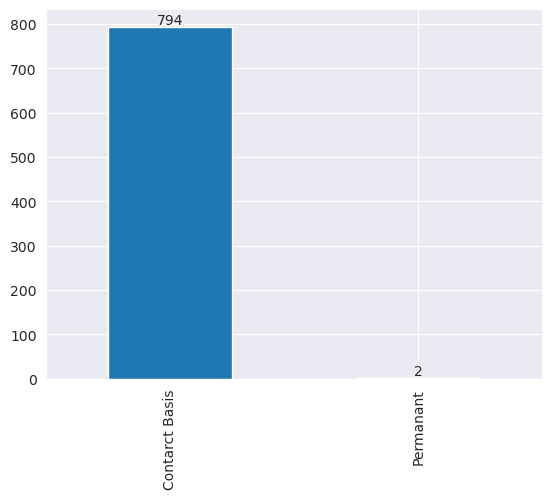

In [1246]:
temp_plot = df_employee['Employment_Type'].value_counts().plot(kind='bar')
temp_plot.bar_label(temp_plot.containers[0], labels=df_employee['Employment_Type'].value_counts())
plt.show()

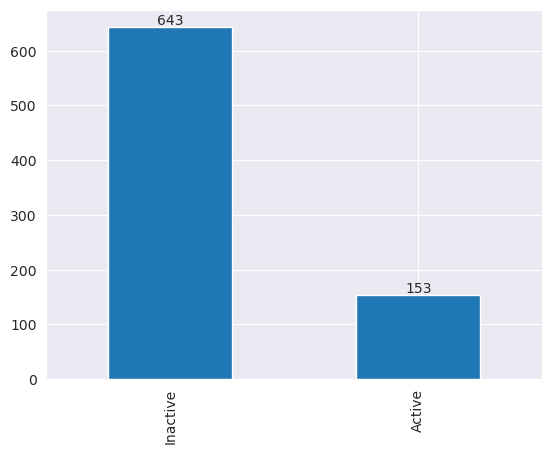

In [1247]:
temp_plot = df_employee['Status'].value_counts().plot(kind='bar')
temp_plot.bar_label(temp_plot.containers[0], labels=df_employee['Status'].value_counts())
plt.show()

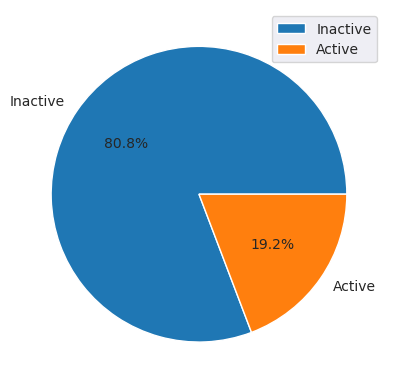

In [1248]:
plt.pie(df_employee['Status'].value_counts(), labels=df_employee['Status'].unique(), autopct='%1.1f%%')
plt.legend()
plt.show()

In [1249]:
# temp_plot = df_employee['Designation'].value_counts().plot(kind='pie')
# plt.legend()
# plt.show()

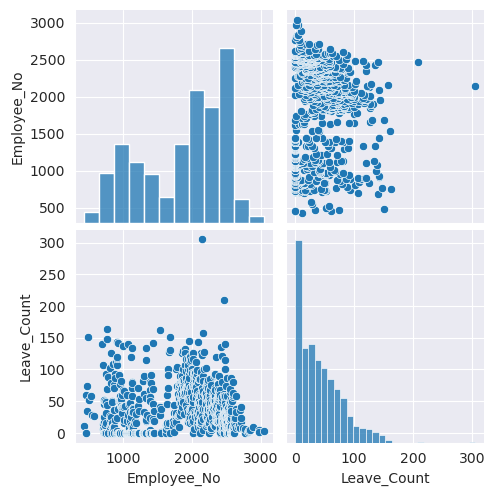

In [1250]:
seaborn.pairplot(df_employee)

In [1251]:
df_employee_inactive_contract_based = pd.DataFrame(df_employee.loc[(df_employee['Status'] == 'Inactive') & (df_employee['Employment_Type'] == 'Contarct Basis')])
df_employee_inactive_contract_based['Date_Joined'] = pd.to_datetime(df_employee_inactive_contract_based['Date_Joined'])
df_employee_inactive_contract_based['Date_Resigned'] = pd.to_datetime(df_employee_inactive_contract_based['Date_Resigned'], errors='coerce')
df_employee_inactive_contract_based['Employment_Duration'] = df_employee_inactive_contract_based['Date_Resigned'].fillna(df_employee_inactive_contract_based['Inactive_Date']) - df_employee_inactive_contract_based['Date_Joined'] + pd.Timedelta(days=1)
df_employee_inactive_contract_based = df_employee_inactive_contract_based.drop(df_employee_inactive_contract_based[df_employee_inactive_contract_based['Employment_Duration'] < pd.Timedelta(days=0)].index)
df_employee_inactive_contract_based['Unavailability_Factor'] = df_employee_inactive_contract_based['Leave_Count'] / df_employee_inactive_contract_based['Employment_Duration'].dt.days

# Annotating attrition or not. If the resignation date is a multiple of 1 year contract, we don't consider that as attrition.
df_employee_inactive_contract_based.loc[df_employee_inactive_contract_based['Employment_Duration'].dt.days % 365 == 0, 'Is_Attrition'] = 0
df_employee_inactive_contract_based.loc[df_employee_inactive_contract_based['Employment_Duration'].dt.days % 365 != 0, 'Is_Attrition'] = 1
df_employee_inactive_contract_based['Employment_Duration'].describe()

count                            641
mean     205 days 04:36:19.095163806
std      184 days 18:07:16.742888928
min                  1 days 00:00:00
25%                 68 days 00:00:00
50%                158 days 00:00:00
75%                291 days 00:00:00
max                933 days 00:00:00
Name: Employment_Duration, dtype: object

In [1252]:
# Too little permanent employees.

# df_employee_inactive_permanent =  pd.DataFrame(df_employee.loc[(df_employee['Status'] == 'Inactive') & (df_employee['Employment_Type'] == 'Permanant')])
# df_employee_inactive_permanent['Date_Joined'] = pd.to_datetime(df_employee_inactive_permanent['Date_Joined'])
# df_employee_inactive_permanent['Date_Resigned'] = pd.to_datetime(df_employee_inactive_permanent['Date_Resigned'], errors='coerce')
# df_employee_inactive_permanent['Employment_Duration'] = df_employee_inactive_permanent['Date_Resigned'] - df_employee_inactive_permanent['Date_Joined'] + pd.Timedelta(days=1)
# df_employee_inactive_permanent['Unavailability_Factor'] = df_employee_inactive_permanent['Leave_Count'] / df_employee_inactive_permanent['Employment_Duration'].dt.days
# df_employee_inactive_permanent['Employment_Duration'].describe()

In [1253]:
# Too little permanent employees.

# df_employee_inactive = pd.DataFrame(df_employee.loc[(df_employee['Status'] == 'Inactive')])
# df_employee_inactive['Date_Joined'] = pd.to_datetime(df_employee_inactive['Date_Joined'])
# df_employee_inactive['Date_Resigned'] = pd.to_datetime(df_employee_inactive['Date_Resigned'], errors='coerce')
# df_employee_inactive['Employment_Duration'] = df_employee_inactive['Date_Resigned'] - df_employee_inactive['Date_Joined'] + pd.Timedelta(days=1)
# df_employee_inactive['Unavailability_Factor'] = df_employee_inactive['Leave_Count'] / df_employee_inactive['Employment_Duration'].dt.days
# df_employee_inactive['Employment_Duration'].describe()

In [1254]:
# Active contract base employee analysis.
from datetime import datetime
df_employee_active_contract_based = pd.DataFrame(df_employee.loc[(df_employee['Status'] == 'Active') & (df_employee['Employment_Type'] == 'Contarct Basis')])
df_employee_active_contract_based['Date_Joined'] = pd.to_datetime(df_employee_active_contract_based['Date_Joined'])
df_employee_active_contract_based['Employment_Duration'] = analysis_period_end_time - df_employee_active_contract_based['Date_Joined'] + pd.Timedelta(days=1)
df_employee_active_contract_based['Unavailability_Factor'] = df_employee_active_contract_based['Leave_Count'] / df_employee_active_contract_based['Employment_Duration'].dt.days
# Annotating active employees as non-attrition.
df_employee_active_contract_based['Is_Attrition'] = 0
df_employee_active_contract_based['Employment_Duration'].describe()

count                            152
mean     458 days 21:09:27.421052632
std      258 days 03:59:08.662802828
min                 12 days 23:59:59
25%                296 days 17:59:59
50%                368 days 11:59:59
75%                537 days 11:59:59
max               1065 days 23:59:59
Name: Employment_Duration, dtype: object

In [1255]:
df_employee_inactive_contract_based['Leave_Count'].describe()

count    641.000000
mean      38.219969
std       33.486809
min        0.000000
25%       10.000000
50%       32.000000
75%       58.500000
max      163.000000
Name: Leave_Count, dtype: float64

In [1256]:
df_employee_active_contract_based['Leave_Count'].describe()

count    152.000000
mean      55.019737
std       50.304565
min        0.000000
25%       12.500000
50%       49.250000
75%       82.375000
max      305.000000
Name: Leave_Count, dtype: float64

In [1257]:
df_employee_inactive_contract_based['Unavailability_Factor'].describe()

count    641.000000
mean       0.512923
std        1.840379
min        0.000000
25%        0.059783
50%        0.215827
75%        0.363222
max       20.000000
Name: Unavailability_Factor, dtype: float64

In [1258]:
df_employee_active_contract_based['Unavailability_Factor'].describe()

count    152.000000
mean       0.127464
std        0.112425
min        0.000000
25%        0.045296
50%        0.108324
75%        0.190642
max        0.626283
Name: Unavailability_Factor, dtype: float64

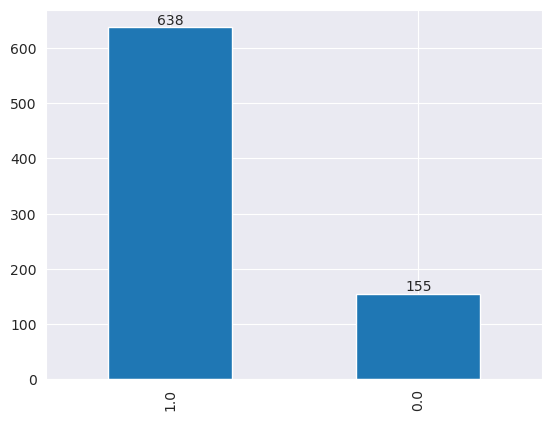

In [1259]:
# Joining tables for attrition.
df_employee_for_modeling = pd.concat([df_employee_inactive_contract_based, df_employee_active_contract_based])
df_employee_for_modeling['Employment_Duration'] = df_employee_for_modeling['Employment_Duration'].dt.days
temp_plot = df_employee_for_modeling['Is_Attrition'].value_counts().plot(kind='bar')
temp_plot.bar_label(temp_plot.containers[0], labels=df_employee_for_modeling['Is_Attrition'].value_counts())
plt.show()

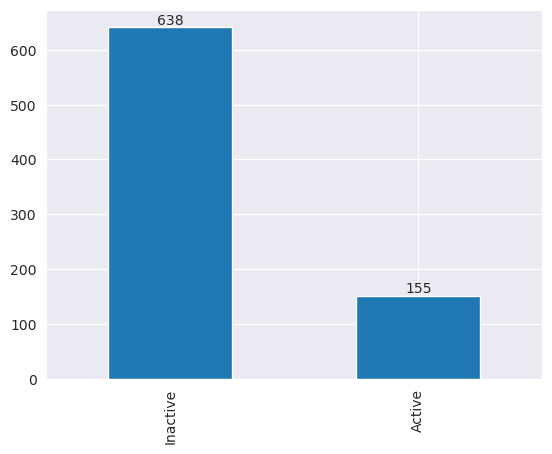

In [1260]:
temp_plot = df_employee_for_modeling['Status'].value_counts().plot(kind='bar')
temp_plot.bar_label(temp_plot.containers[0], labels=df_employee_for_modeling['Is_Attrition'].value_counts())
plt.show()

In [1261]:
x = df_employee_for_modeling[['Employment_Duration', 'Leave_Count', 'Unavailability_Factor']]
y = df_employee_for_modeling['Is_Attrition']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=55)
model = LogisticRegression()
model.fit(x_train, y_train)

LogisticRegression()

In [1262]:
y_predicted = model.predict(x_test)
accuracy = accuracy_score(y_test, y_predicted)
print(f'Accuracy: {accuracy}')
precision = precision_score(y_test, y_predicted)
print(f'Precision: {precision}')
recall = recall_score(y_test, y_predicted)
print(f'Recall: {recall}')
f1 = f1_score(y_test, y_predicted)
print(f'F1 score: {f1}')
r2 = f1_score(y_test, y_predicted)
print(f'R2 score: {r2}')

Accuracy: 0.8050314465408805
Precision: 0.8243243243243243
Recall: 0.9606299212598425
F1 score: 0.8872727272727272
R2 score: 0.8872727272727272
